# Practical Work 02 - Polygon Triangulation

| Information | Details     |
| ----------- | ----------- |
| Course      | Computational Geometry (`INF2604`) |
| Professor   | Waldemar Celes (<celes@inf.puc-rio.br>) |
| Student     | Gabriel Ribeiro Gomes (<ggomes@inf.puc-rio.br>, <ribeiroggabriel@gmail.com>) |

## Setup and problem definition

We need to generate a report that fulfills the following requirements:

- Implements a triangulation algorithm for simple polygons.
- The entry point is a simple polygon defined by a list of its vertices in counter-clockwise order.
- The output is a list of triangles that form a triangulation of the input polygon.

## Code Implementation

In [2]:
import math

import matplotlib.pyplot as plt

from matplotlib.patches import Polygon as MplPolygon


Point = tuple[float, float]
Triangle = tuple[Point, Point, Point]

EPS = 1e-9

### Helper functions

In [ ]:
def cross(a: Point, b: Point, c: Point) -> float:
    """Signed 2D cross product of vectors (b - a) and (c - a).

    Geometric meaning:
      - Returns the signed area of the parallelogram spanned by (b - a) and (c - a).
      - Sign > 0: point c is to the left of the directed segment a→b (CCW turn).
      - Sign < 0: point c is to the right of the directed segment a→b (CW turn).
      - Sign ≈ 0: points are (approximately) collinear.

    Args:
      a: Origin point of the vector pair.
      b: Second point; defines the first vector (b - a).
      c: Third point; defines the second vector (c - a).

    Returns:
      Scalar value of the 2D cross product: (b - a) × (c - a).
    """
    ab_x = b[0] - a[0]
    ab_y = b[1] - a[1]
    ac_x = c[0] - a[0]
    ac_y = c[1] - a[1]
    return ab_x * ac_y - ab_y * ac_x


def signed_area(poly: list[Point]) -> float:
    """Signed area of a simple polygon via the shoelace formula.

    Convention:
      - Area > 0 when vertices are in counterclockwise (CCW) order.
      - Area < 0 when vertices are in clockwise (CW) order.

    Args:
      poly: List of polygon vertices (implicitly closed).

    Returns:
      Signed area (in squared units of the coordinates).
    """
    accumulator = 0.0
    num_vertices = len(poly)
    for i in range(num_vertices):
        x_i, y_i = poly[i]
        x_next, y_next = poly[(i + 1) % num_vertices]
        accumulator += x_i * y_next - x_next * y_i
    return 0.5 * accumulator


def is_clockwise(poly: list[Point]) -> bool:
    """Return True if polygon vertices are in clockwise (CW) order.

    Note:
      This relies on the sign of the signed area. With heavy floating-point noise,
      consider comparing against a tolerance (e.g., ±EPS) externally.

    Args:
      poly: List of polygon vertices.

    Returns:
      True if signed area is negative (CW), False otherwise.
    """
    return signed_area(poly) < 0.0


def is_convex(a: Point, b: Point, c: Point) -> bool:
    """Check if the oriented angle a→b→c is convex (CCW turn).

    Criterion:
      Consider the angle convex if cross(a, b, c) is strictly greater than EPS.

    Args:
      a: Previous vertex.
      b: Current vertex (angle at this point).
      c: Next vertex.

    Returns:
      True if the angle is convex (CCW above EPS), False otherwise.
    """
    return cross(a, b, c) > EPS


def point_in_triangle(p: Point, a: Point, b: Point, c: Point) -> bool:
    """Test whether point p lies inside (or on the boundary of) triangle abc.

    Method:
      Uses the signs of cross products to ensure p lies on the same side
      of each triangle edge, allowing an EPS tolerance for boundary inclusion.

    Args:
      p: Query point.
      a: First triangle vertex.
      b: Second triangle vertex.
      c: Third triangle vertex.

    Returns:
      True if p is inside or on the boundary of triangle abc; False otherwise.
    """
    orient_ab_p = cross(a, b, p)
    orient_bc_p = cross(b, c, p)
    orient_ca_p = cross(c, a, p)

    has_positive = (orient_ab_p > EPS) or (orient_bc_p > EPS) or (orient_ca_p > EPS)
    has_negative = (orient_ab_p < -EPS) or (orient_bc_p < -EPS) or (orient_ca_p < -EPS)

    # If there is at least one positive and one negative, p lies outside.
    return not (has_positive and has_negative)


### Ear Clipping Functions

In [ ]:
def find_ear(polygon: list[Point]) -> tuple[int, Triangle] | None:
    """
    Checks for an ear in the polygon.

    Arguments:
        polygon: list of points representing a simple polygon (no holes, no
            self-intersections)

    Returns:
        (vertex_index, (prev_vertex, curr_vertex, next_vertex)) where the three points
        form the ear triangle and curr_vertex is at polygon[vertex_index],
        or None if no ear is found (degenerate case).
    """
    num_vertices = len(polygon)

    for vertex_index in range(num_vertices):
        prev_vertex = polygon[(vertex_index - 1) % num_vertices]
        curr_vertex = polygon[vertex_index]
        next_vertex = polygon[(vertex_index + 1) % num_vertices]

        if not is_convex(prev_vertex, curr_vertex, next_vertex):
            continue

        is_ear = True
        for other_index in range(num_vertices):
            if other_index in {
                (vertex_index - 1) % num_vertices,
                vertex_index,
                (vertex_index + 1) % num_vertices,
            }:
                continue

            other_point = polygon[other_index]
            if point_in_triangle(other_point, prev_vertex, curr_vertex, next_vertex):
                is_ear = False
                break

        if is_ear:
            return vertex_index, (prev_vertex, curr_vertex, next_vertex)

    return None


def triangulate(polygon: list[Point]) -> list[Triangle]:
    """
    Triangulates a simple polygon (without holes) using the ear clipping method.
    Returns a list of triangles as tuples of points.
    """
    if len(polygon) < 3:
        return []

    # Ensure polygon orientation is counterclockwise
    remaining_vertices = (
        polygon[:] if not is_clockwise(polygon)
        else list(reversed(polygon))
    )
    triangles: list[Triangle] = []

    # Remove ears until only one triangle remains
    iteration_guard = 0
    while len(remaining_vertices) > 3:
        found_ear = find_ear(remaining_vertices)

        if found_ear is None:
            # Degenerate case (strong collinearities, numerical noise)
            # Strategy: remove the vertex with the smallest local area
            num_vertices = len(remaining_vertices)
            min_local_area = math.inf
            min_area_index = None

            for vertex_index in range(num_vertices):
                prev_vertex = remaining_vertices[(vertex_index - 1) % num_vertices]
                curr_vertex = remaining_vertices[vertex_index]
                next_vertex = remaining_vertices[(vertex_index + 1) % num_vertices]

                local_area = abs(cross(prev_vertex, curr_vertex, next_vertex))
                if local_area < min_local_area:
                    min_local_area = local_area
                    min_area_index = vertex_index

            # If there’s still area, record the triangle; otherwise just remove the vertex
            prev_vertex = remaining_vertices[(min_area_index - 1) % num_vertices]
            curr_vertex = remaining_vertices[min_area_index]
            next_vertex = remaining_vertices[(min_area_index + 1) % num_vertices]

            if min_local_area > 1e-18:
                triangles.append((prev_vertex, curr_vertex, next_vertex))

            del remaining_vertices[min_area_index]

        else:
            ear_index, ear_triangle = found_ear
            triangles.append(ear_triangle)
            del remaining_vertices[ear_index]

        iteration_guard += 1
        if iteration_guard > 5 * len(polygon):
            raise RuntimeError("Unexpected loop; check if the polygon is simple.")

    triangles.append(
        (remaining_vertices[0], remaining_vertices[1], remaining_vertices[2])
    )
    return triangles

### Visualization Functions

In [17]:
def draw_polygon(vertices: list[Point], ax=None, edge_color: str = "#BD5E35"):
    """
    Draws a polygon given a list of vertices.
    """
    if ax is None:
        _, ax = plt.subplots()

    x_coords = [vertex[0] for vertex in vertices] + [vertices[0][0]]
    y_coords = [vertex[1] for vertex in vertices] + [vertices[0][1]]

    ax.plot(x_coords, y_coords, marker="o", color=edge_color)
    ax.set_aspect("equal", adjustable="box")
    return ax


def draw_triangulation(vertices: list[Point], triangles: list[Triangle]):
    """
    Draws a triangulation over a polygon.
    """
    fig, ax = plt.subplots()

    # Draw triangles
    for triangle in triangles:
        patch = MplPolygon(
            triangle,
            fc=None,
            ec="#23B52C",
            fill=False,
            linewidth=1.2,
        )
        ax.add_patch(patch)

    # Draw original polygon
    draw_polygon(vertices, ax=ax, edge_color="#191970")

    plt.xlabel("Eixo X")
    plt.ylabel("Eixo Y")
    plt.show()


def calculate_total_area(triangles: list[Triangle]) -> float:
    """
    Calculates the total area of a set of triangles.
    """
    return sum(abs(cross(v1, v2, v3)) * 0.5 for v1, v2, v3 in triangles)


## Experiments

Experimento 1
n_triangles: 13 | area_polygon: 30827.500 | area_triangulation: 30827.500


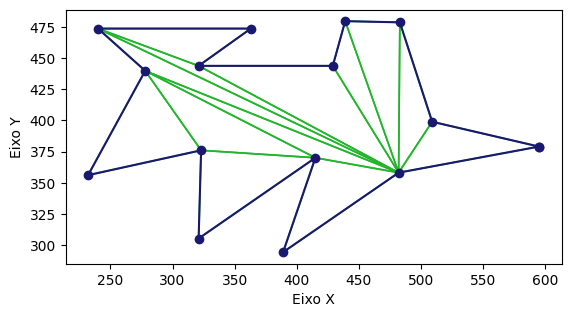

Experimento 2
n_triangles: 18 | area_polygon: 64914.500 | area_triangulation: 64914.500


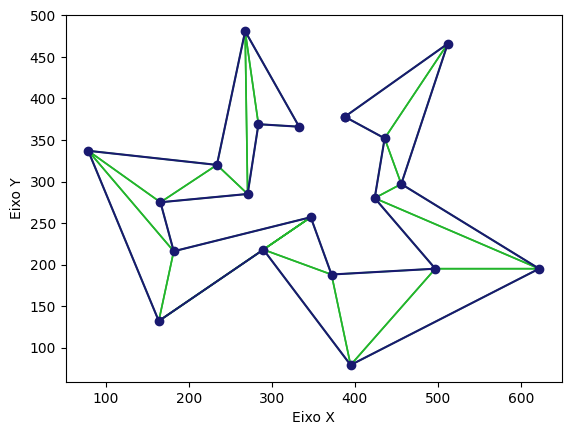

In [18]:
# ==============================
# Experimento 1
# ==============================
print("Experimento 1")

polygon_experiment_1 = [
    (595, 379), (509, 399), (483, 479), (439, 480), (429, 444),
    (321, 444), (363, 474), (240, 474), (278, 440), (232, 356),
    (323, 376), (321, 305), (415, 370), (389, 294), (482, 358),
]

triangles_exp1 = triangulate(polygon_experiment_1)

print(
    f"n_triangles: {len(triangles_exp1)} | "
    f"area_polygon: {abs(signed_area(polygon_experiment_1)):.3f} | "
    f"area_triangulation: {calculate_total_area(triangles_exp1):.3f}"
)

draw_triangulation(polygon_experiment_1, triangles_exp1)


# ==============================
# Experimento 2
# ==============================
print("Experimento 2")

polygon_experiment_2 = [
    (388, 378), (512, 466), (456, 297), (622, 195), (395, 79),
    (290, 218), (164, 132), (79, 337), (234, 320), (268, 481),
    (333, 366), (284, 369), (271, 285), (166, 275), (182, 216),
    (347, 257), (372, 188), (497, 195), (424, 280), (436, 352),
]

triangles_exp2 = triangulate(polygon_experiment_2)

print(
    f"n_triangles: {len(triangles_exp2)} | "
    f"area_polygon: {abs(signed_area(polygon_experiment_2)):.3f} | "
    f"area_triangulation: {calculate_total_area(triangles_exp2):.3f}"
)

draw_triangulation(polygon_experiment_2, triangles_exp2)


n_triangles: 6 | area_polygon: 2325.000 | area_triangulation: 2325.000


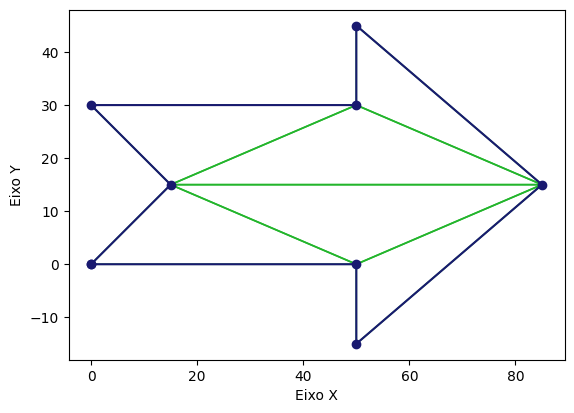

n_triangles: 6 | area_polygon: 1300.000 | area_triangulation: 1300.000


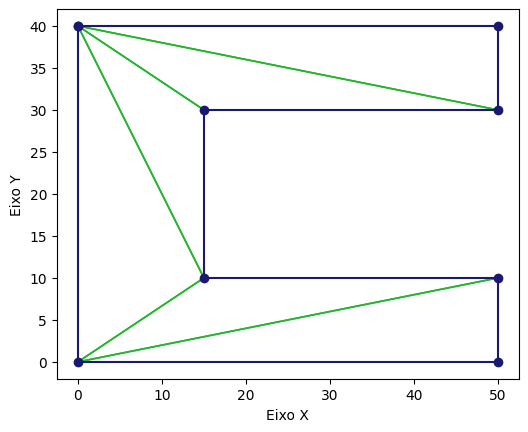

In [19]:
# ==============================
# Experimento 3 — "seta" (concavo, 8 vértices)
# ==============================
polygon_experiment_3 = [
    (0, 0),
    (50, 0),
    (50, -15),
    (85, 15),
    (50, 45),
    (50, 30),
    (0, 30),
    (15, 15),
]

triangles_exp3 = triangulate(polygon_experiment_3)

print(
    f"n_triangles: {len(triangles_exp3)} | "
    f"area_polygon: {abs(signed_area(polygon_experiment_3)):.3f} | "
    f"area_triangulation: {calculate_total_area(triangles_exp3):.3f}"
)

draw_triangulation(polygon_experiment_3, triangles_exp3)


# ==============================
# Experimento 4 — formato de "C" (concavo, 8 vértices)
# ==============================
polygon_experiment_4 = [
    (0, 40),
    (50, 40),
    (50, 30),
    (15, 30),
    (15, 10),
    (50, 10),
    (50, 0),
    (0, 0),
]

triangles_exp4 = triangulate(polygon_experiment_4)

print(
    f"n_triangles: {len(triangles_exp4)} | "
    f"area_polygon: {abs(signed_area(polygon_experiment_4)):.3f} | "
    f"area_triangulation: {calculate_total_area(triangles_exp4):.3f}"
)

draw_triangulation(polygon_experiment_4, triangles_exp4)
